In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [2]:
# Root directory for dataset
dataroot = "abstract_images"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 32

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 401

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

clamp_num=0.01

epoch_restore = 150
checkpoint_path = "abstract-art-generation-dcgan-checkpoints/{}epochs.chkpt".format(epoch_restore)

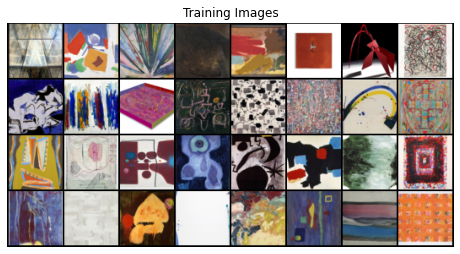

In [3]:
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('Norm') != -1:
        3 # Modified 2: Changed batch to norm
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        #nn.init.constant_(m.bias.data, 0) # Modified 3

In [5]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [6]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.02.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [26]:
# Generate Generator Tree
# x = torch.randn(batch_size, nz, 1, 1, device=device).requires_grad_(True)
# y = netG(x)
# from torchviz import make_dot
# make_dot(y, params=dict(list(netG.named_parameters()))).render()

'Digraph.gv.pdf'

In [30]:
# Generate Discriminator Tree
# for epoch in range(1):
#     for real_images, _ in tqdm(dataloader):
#         # Train discriminator
#         # modification: clip param for discriminator
#         for parm in netD.parameters():
#             parm.data.clamp_(-clamp_num, clamp_num)
#         y = netD(real_images)
#         make_dot(y, params=dict(list(netD.named_parameters()))).render()
            

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            # Modified 1: Remove Sigmoid
            #nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [8]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )
)


In [9]:
from torchvision.utils import make_grid
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

torch.Size([32, 3, 64, 64])


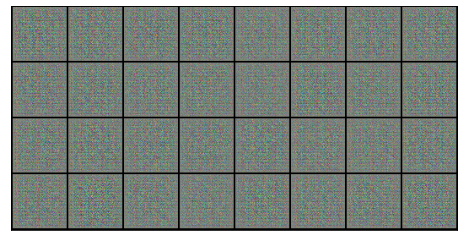

In [10]:
noise = torch.randn(batch_size, nz, 1, 1) # random latent tensors
fake_images = netG(noise)
print(fake_images.shape)
show_images(fake_images)

In [11]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = netD(real_images)
    #modification: remove binary cross entropy
        #real_targets = torch.ones(real_images.size(0), 1, device=device)
        #real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_loss = -torch.mean(real_preds)
        
    # Generate fake images
    latent = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = netG(latent)

    # Pass fake images through discriminator
    #modification: remove binary cross entropy
        #fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = netD(fake_images)
        #fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_loss = torch.mean(fake_preds)

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_loss.item(), fake_loss.item()

In [12]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, nz, 1, 1, device=device)
    fake_images = netG(latent)
    
    # Try to fool the discriminator
    preds = netD(fake_images)
    #modificationL remove binary cross entropy
        #targets = torch.ones(batch_size, 1, device=device)
    loss = -torch.mean(preds)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [13]:
from torchvision.utils import save_image
sample_dir = 'generated_wgan'
os.makedirs(sample_dir, exist_ok=True)

In [14]:
def save_samples(index, latent_tensors, show=True):
    fake_images = netG(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [15]:
fixed_latent = torch.randn(64, nz, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


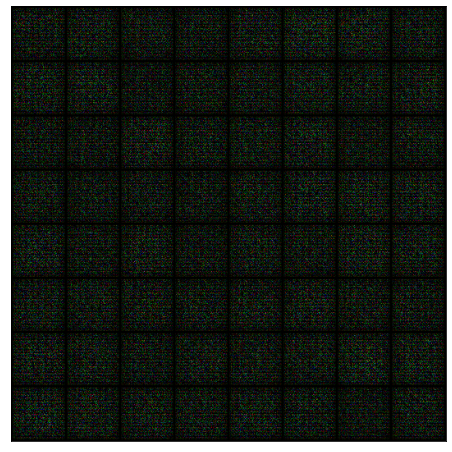

In [16]:
save_samples(0, fixed_latent)

In [17]:
def save_epoch(save_no,opt_g,opt_d,netG,netD):
    end_epoch = save_no - 1
    save_file = "{}epochs_wgan.chkpt".format(end_epoch)

    torch.save({
            'generator_state_dict': netG.state_dict(),
            'discriminator_state_dict': netD.state_dict(),
            'generator_optim_state_dict' : opt_g.state_dict(),
            'discriminator_optim_state_dict' : opt_d.state_dict(),}, save_file)

In [18]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [19]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    global opt_d
    global opt_g
    opt_d = torch.optim.RMSprop(netD.parameters(), lr=lr)
    opt_g = torch.optim.RMSprop(netG.parameters(), lr=lr)
    
    save_list_epoch = [1,50,100,150,200,250,300,350,400]
    
    for epoch in range(epochs):
        if epoch in save_list_epoch:
            save_epoch(epoch,opt_g,opt_d,netG,netD)
        for real_images, _ in tqdm(dataloader):
            # Train discriminator
            # modification: clip param for discriminator
            for parm in netD.parameters():
                parm.data.clamp_(-clamp_num, clamp_num)
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [20]:
history = fit(num_epochs, lr)


Epoch [1/401], loss_g: 0.2173, loss_d: -0.3932, real_score: -0.1180, fake_score: -0.2752
Saving generated-images-0001.png



Epoch [2/401], loss_g: 0.6454, loss_d: -0.3836, real_score: -0.2912, fake_score: -0.0924
Saving generated-images-0002.png



Epoch [3/401], loss_g: 0.2893, loss_d: -0.4415, real_score: -0.0516, fake_score: -0.3899
Saving generated-images-0003.png



Epoch [4/401], loss_g: 0.1637, loss_d: -0.7398, real_score: -0.2571, fake_score: -0.4827
Saving generated-images-0004.png



Epoch [5/401], loss_g: 0.3147, loss_d: -0.1439, real_score: -0.4069, fake_score: 0.2630
Saving generated-images-0005.png



Epoch [6/401], loss_g: 0.5084, loss_d: -0.4436, real_score: -0.2133, fake_score: -0.2303
Saving generated-images-0006.png



Epoch [7/401], loss_g: 0.4481, loss_d: -0.6186, real_score: -0.1963, fake_score: -0.4223
Saving generated-images-0007.png



Epoch [8/401], loss_g: -0.1161, loss_d: -0.0233, real_score: -0.5035, fake_score: 0.4801
Saving generated-images-0008.png



Epoch [9/401], loss_g: 0.4787, loss_d: -0.2587, real_score: -0.2722, fake_score: 0.0135
Saving generated-images-0009.png



Epoch [10/401], loss_g: 0.4842, loss_d: -0.7128, real_score: -0.3300, fake_score: -0.3828
Saving generated-images-0010.png



Epoch [11/401], loss_g: -0.2164, loss_d: -0.0715, real_score: -0.5350, fake_score: 0.4634
Saving generated-images-0011.png



Epoch [12/401], loss_g: 0.2877, loss_d: -0.4085, real_score: 0.0442, fake_score: -0.4527
Saving generated-images-0012.png



Epoch [13/401], loss_g: -0.3295, loss_d: -0.0018, real_score: -0.3237, fake_score: 0.3219
Saving generated-images-0013.png



Epoch [14/401], loss_g: 0.2006, loss_d: -0.1247, real_score: -0.4489, fake_score: 0.3242
Saving generated-images-0014.png



Epoch [15/401], loss_g: 0.4231, loss_d: -0.1348, real_score: -0.4970, fake_score: 0.3621
Saving generated-images-0015.png



Epoch [16/401], loss_g: 0.3799, loss_d: -0.5175, real_score: -0.4361, fake_score: -0.0814
Saving generated-images-0016.png



Epoch [17/401], loss_g: 0.4226, loss_d: -0.2705, real_score: -0.4951, fake_score: 0.2246
Saving generated-images-0017.png



Epoch [18/401], loss_g: 0.6106, loss_d: -0.7549, real_score: -0.4571, fake_score: -0.2978
Saving generated-images-0018.png



Epoch [19/401], loss_g: 0.5445, loss_d: -0.4306, real_score: -0.3268, fake_score: -0.1038
Saving generated-images-0019.png



Epoch [20/401], loss_g: 0.5780, loss_d: -0.3354, real_score: -0.3200, fake_score: -0.0154
Saving generated-images-0020.png



Epoch [21/401], loss_g: -0.0451, loss_d: -0.4352, real_score: 0.1361, fake_score: -0.5714
Saving generated-images-0021.png



Epoch [22/401], loss_g: 0.2886, loss_d: -0.1582, real_score: -0.5248, fake_score: 0.3666
Saving generated-images-0022.png



Epoch [23/401], loss_g: 0.5464, loss_d: -0.4371, real_score: -0.3785, fake_score: -0.0586
Saving generated-images-0023.png



Epoch [24/401], loss_g: 0.3404, loss_d: -0.6274, real_score: -0.2553, fake_score: -0.3721
Saving generated-images-0024.png



Epoch [25/401], loss_g: 0.5999, loss_d: -0.5160, real_score: -0.4273, fake_score: -0.0887
Saving generated-images-0025.png



Epoch [26/401], loss_g: 0.5712, loss_d: -0.6257, real_score: -0.3685, fake_score: -0.2572
Saving generated-images-0026.png



Epoch [27/401], loss_g: 0.4869, loss_d: -0.1935, real_score: -0.5433, fake_score: 0.3498
Saving generated-images-0027.png



Epoch [28/401], loss_g: 0.4895, loss_d: -0.5801, real_score: -0.3047, fake_score: -0.2754
Saving generated-images-0028.png



Epoch [29/401], loss_g: 0.3931, loss_d: -0.5173, real_score: -0.2861, fake_score: -0.2312
Saving generated-images-0029.png



Epoch [30/401], loss_g: 0.4624, loss_d: -0.5985, real_score: -0.2357, fake_score: -0.3628
Saving generated-images-0030.png



Epoch [31/401], loss_g: 0.3133, loss_d: -0.6670, real_score: -0.2612, fake_score: -0.4058
Saving generated-images-0031.png



Epoch [32/401], loss_g: 0.5867, loss_d: -0.5274, real_score: -0.3318, fake_score: -0.1955
Saving generated-images-0032.png



Epoch [33/401], loss_g: 0.2531, loss_d: -0.3838, real_score: 0.0087, fake_score: -0.3925
Saving generated-images-0033.png



Epoch [34/401], loss_g: -0.0923, loss_d: -0.3610, real_score: 0.1841, fake_score: -0.5451
Saving generated-images-0034.png



Epoch [35/401], loss_g: 0.4238, loss_d: -0.2047, real_score: -0.5236, fake_score: 0.3189
Saving generated-images-0035.png



Epoch [36/401], loss_g: 0.5673, loss_d: -0.7300, real_score: -0.4154, fake_score: -0.3146
Saving generated-images-0036.png



Epoch [37/401], loss_g: 0.1459, loss_d: -0.5106, real_score: -0.2000, fake_score: -0.3106
Saving generated-images-0037.png



Epoch [38/401], loss_g: 0.4954, loss_d: -0.6805, real_score: -0.3668, fake_score: -0.3137
Saving generated-images-0038.png



Epoch [39/401], loss_g: -0.1695, loss_d: -0.4094, real_score: 0.0893, fake_score: -0.4987
Saving generated-images-0039.png



Epoch [40/401], loss_g: -0.1212, loss_d: -0.4966, real_score: 0.0109, fake_score: -0.5074
Saving generated-images-0040.png



Epoch [41/401], loss_g: 0.3378, loss_d: -0.1811, real_score: -0.5373, fake_score: 0.3562
Saving generated-images-0041.png



Epoch [42/401], loss_g: -0.1345, loss_d: -0.4042, real_score: 0.1642, fake_score: -0.5684
Saving generated-images-0042.png



Epoch [43/401], loss_g: 0.6185, loss_d: -0.6289, real_score: -0.5250, fake_score: -0.1039
Saving generated-images-0043.png



Epoch [44/401], loss_g: 0.1439, loss_d: -0.6016, real_score: -0.2050, fake_score: -0.3966
Saving generated-images-0044.png



Epoch [45/401], loss_g: 0.3812, loss_d: -0.5337, real_score: -0.2377, fake_score: -0.2960
Saving generated-images-0045.png



Epoch [46/401], loss_g: -0.0618, loss_d: -0.4376, real_score: 0.0730, fake_score: -0.5106
Saving generated-images-0046.png



Epoch [47/401], loss_g: -0.2429, loss_d: -0.3229, real_score: 0.1960, fake_score: -0.5190
Saving generated-images-0047.png



Epoch [48/401], loss_g: 0.2920, loss_d: -0.6282, real_score: -0.2783, fake_score: -0.3499
Saving generated-images-0048.png



Epoch [49/401], loss_g: 0.5791, loss_d: -0.5310, real_score: -0.3984, fake_score: -0.1326
Saving generated-images-0049.png



Epoch [50/401], loss_g: 0.5785, loss_d: -0.4357, real_score: -0.5346, fake_score: 0.0989
Saving generated-images-0050.png



Epoch [51/401], loss_g: 0.0328, loss_d: -0.5543, real_score: -0.0855, fake_score: -0.4689
Saving generated-images-0051.png



Epoch [52/401], loss_g: 0.2026, loss_d: -0.5307, real_score: -0.1565, fake_score: -0.3742
Saving generated-images-0052.png



Epoch [53/401], loss_g: 0.2551, loss_d: -0.6925, real_score: -0.2352, fake_score: -0.4573
Saving generated-images-0053.png



Epoch [54/401], loss_g: -0.1682, loss_d: -0.5297, real_score: -0.0248, fake_score: -0.5049
Saving generated-images-0054.png



Epoch [55/401], loss_g: 0.4473, loss_d: -0.5847, real_score: -0.3092, fake_score: -0.2755
Saving generated-images-0055.png



Epoch [56/401], loss_g: -0.1103, loss_d: -0.5372, real_score: -0.0016, fake_score: -0.5355
Saving generated-images-0056.png



Epoch [57/401], loss_g: -0.1370, loss_d: -0.4031, real_score: 0.1207, fake_score: -0.5238
Saving generated-images-0057.png



Epoch [58/401], loss_g: 0.5463, loss_d: -0.3246, real_score: -0.4625, fake_score: 0.1378
Saving generated-images-0058.png



Epoch [59/401], loss_g: -0.3151, loss_d: -0.5314, real_score: -0.0567, fake_score: -0.4746
Saving generated-images-0059.png



Epoch [60/401], loss_g: 0.5133, loss_d: -0.6112, real_score: -0.3537, fake_score: -0.2575
Saving generated-images-0060.png



Epoch [61/401], loss_g: 0.5131, loss_d: -0.4341, real_score: -0.2300, fake_score: -0.2041
Saving generated-images-0061.png



Epoch [62/401], loss_g: 0.5003, loss_d: -0.2827, real_score: -0.5167, fake_score: 0.2340
Saving generated-images-0062.png



Epoch [63/401], loss_g: 0.5159, loss_d: -0.4170, real_score: -0.3392, fake_score: -0.0778
Saving generated-images-0063.png



Epoch [64/401], loss_g: -0.0417, loss_d: -0.0802, real_score: -0.5719, fake_score: 0.4917
Saving generated-images-0064.png



Epoch [65/401], loss_g: 0.5638, loss_d: -0.4913, real_score: -0.4252, fake_score: -0.0661
Saving generated-images-0065.png



Epoch [66/401], loss_g: 0.4546, loss_d: -0.2604, real_score: -0.5077, fake_score: 0.2473
Saving generated-images-0066.png



Epoch [67/401], loss_g: 0.0798, loss_d: -0.4909, real_score: -0.1943, fake_score: -0.2966
Saving generated-images-0067.png



Epoch [68/401], loss_g: 0.5015, loss_d: -0.2619, real_score: -0.4985, fake_score: 0.2366
Saving generated-images-0068.png



Epoch [69/401], loss_g: 0.3832, loss_d: -0.2094, real_score: -0.4634, fake_score: 0.2541
Saving generated-images-0069.png



Epoch [70/401], loss_g: 0.5432, loss_d: -0.3901, real_score: -0.4217, fake_score: 0.0316
Saving generated-images-0070.png



Epoch [71/401], loss_g: -0.0025, loss_d: -0.3732, real_score: 0.0159, fake_score: -0.3891
Saving generated-images-0071.png



Epoch [72/401], loss_g: 0.0873, loss_d: -0.4695, real_score: -0.1244, fake_score: -0.3451
Saving generated-images-0072.png



Epoch [73/401], loss_g: 0.4612, loss_d: -0.2202, real_score: -0.4997, fake_score: 0.2795
Saving generated-images-0073.png



Epoch [74/401], loss_g: 0.1490, loss_d: -0.4389, real_score: -0.1036, fake_score: -0.3353
Saving generated-images-0074.png



Epoch [75/401], loss_g: 0.4538, loss_d: -0.2880, real_score: -0.4686, fake_score: 0.1806
Saving generated-images-0075.png



Epoch [76/401], loss_g: 0.5506, loss_d: -0.3392, real_score: -0.4419, fake_score: 0.1027
Saving generated-images-0076.png



Epoch [77/401], loss_g: 0.4667, loss_d: -0.4945, real_score: -0.3237, fake_score: -0.1708
Saving generated-images-0077.png



Epoch [78/401], loss_g: 0.4894, loss_d: -0.2622, real_score: -0.4873, fake_score: 0.2251
Saving generated-images-0078.png



Epoch [79/401], loss_g: -0.0723, loss_d: -0.3825, real_score: -0.0561, fake_score: -0.3263
Saving generated-images-0079.png



Epoch [80/401], loss_g: -0.0370, loss_d: -0.3017, real_score: 0.1582, fake_score: -0.4599
Saving generated-images-0080.png



Epoch [81/401], loss_g: 0.4568, loss_d: -0.2793, real_score: -0.4738, fake_score: 0.1945
Saving generated-images-0081.png



Epoch [82/401], loss_g: -0.0013, loss_d: -0.3459, real_score: 0.0094, fake_score: -0.3553
Saving generated-images-0082.png



Epoch [83/401], loss_g: -0.3460, loss_d: -0.2811, real_score: 0.2010, fake_score: -0.4821
Saving generated-images-0083.png



Epoch [84/401], loss_g: 0.0415, loss_d: -0.4621, real_score: -0.0914, fake_score: -0.3707
Saving generated-images-0084.png



Epoch [85/401], loss_g: 0.5404, loss_d: -0.6178, real_score: -0.3493, fake_score: -0.2685
Saving generated-images-0085.png



Epoch [86/401], loss_g: 0.2872, loss_d: -0.1940, real_score: -0.5435, fake_score: 0.3495
Saving generated-images-0086.png



Epoch [87/401], loss_g: 0.4332, loss_d: -0.3053, real_score: -0.2197, fake_score: -0.0857
Saving generated-images-0087.png



Epoch [88/401], loss_g: 0.5258, loss_d: -0.3169, real_score: -0.4757, fake_score: 0.1588
Saving generated-images-0088.png



Epoch [89/401], loss_g: 0.4130, loss_d: -0.2036, real_score: -0.4843, fake_score: 0.2807
Saving generated-images-0089.png



Epoch [90/401], loss_g: 0.5065, loss_d: -0.2722, real_score: -0.4455, fake_score: 0.1733
Saving generated-images-0090.png



Epoch [91/401], loss_g: -0.2036, loss_d: -0.3610, real_score: 0.0727, fake_score: -0.4337
Saving generated-images-0091.png



Epoch [92/401], loss_g: -0.2821, loss_d: -0.3035, real_score: 0.1807, fake_score: -0.4843
Saving generated-images-0092.png



Epoch [93/401], loss_g: -0.0550, loss_d: -0.2986, real_score: 0.2016, fake_score: -0.5001
Saving generated-images-0093.png



Epoch [94/401], loss_g: 0.0446, loss_d: -0.3217, real_score: 0.1163, fake_score: -0.4379
Saving generated-images-0094.png



Epoch [95/401], loss_g: 0.3628, loss_d: -0.2976, real_score: -0.2074, fake_score: -0.0902
Saving generated-images-0095.png



Epoch [96/401], loss_g: 0.4426, loss_d: -0.2280, real_score: -0.4070, fake_score: 0.1790
Saving generated-images-0096.png



Epoch [97/401], loss_g: 0.4265, loss_d: -0.4111, real_score: -0.4022, fake_score: -0.0089
Saving generated-images-0097.png



Epoch [98/401], loss_g: -0.0412, loss_d: -0.2912, real_score: 0.1747, fake_score: -0.4659
Saving generated-images-0098.png



Epoch [99/401], loss_g: -0.0769, loss_d: -0.3329, real_score: 0.1219, fake_score: -0.4547
Saving generated-images-0099.png



Epoch [100/401], loss_g: 0.5411, loss_d: -0.3733, real_score: -0.3836, fake_score: 0.0103
Saving generated-images-0100.png



Epoch [101/401], loss_g: -0.2394, loss_d: -0.3427, real_score: 0.0330, fake_score: -0.3756
Saving generated-images-0101.png



Epoch [102/401], loss_g: -0.2264, loss_d: -0.3843, real_score: -0.0060, fake_score: -0.3783
Saving generated-images-0102.png



Epoch [103/401], loss_g: -0.0164, loss_d: -0.3078, real_score: 0.1363, fake_score: -0.4442
Saving generated-images-0103.png



Epoch [104/401], loss_g: 0.4958, loss_d: -0.3815, real_score: -0.3329, fake_score: -0.0486
Saving generated-images-0104.png



Epoch [105/401], loss_g: -0.0665, loss_d: -0.2870, real_score: 0.0439, fake_score: -0.3308
Saving generated-images-0105.png



Epoch [106/401], loss_g: -0.2089, loss_d: -0.3497, real_score: 0.0847, fake_score: -0.4344
Saving generated-images-0106.png



Epoch [107/401], loss_g: 0.4399, loss_d: -0.2316, real_score: -0.4281, fake_score: 0.1965
Saving generated-images-0107.png



Epoch [108/401], loss_g: 0.4073, loss_d: -0.2418, real_score: -0.3863, fake_score: 0.1446
Saving generated-images-0108.png



Epoch [109/401], loss_g: 0.0133, loss_d: -0.4436, real_score: -0.0737, fake_score: -0.3698
Saving generated-images-0109.png



Epoch [110/401], loss_g: -0.3088, loss_d: -0.4132, real_score: 0.0318, fake_score: -0.4451
Saving generated-images-0110.png



Epoch [111/401], loss_g: 0.4385, loss_d: -0.2060, real_score: -0.4260, fake_score: 0.2200
Saving generated-images-0111.png



Epoch [112/401], loss_g: 0.1217, loss_d: -0.2860, real_score: 0.0679, fake_score: -0.3539
Saving generated-images-0112.png



Epoch [113/401], loss_g: 0.4581, loss_d: -0.2133, real_score: -0.3876, fake_score: 0.1743
Saving generated-images-0113.png



Epoch [114/401], loss_g: 0.4342, loss_d: -0.3125, real_score: -0.3454, fake_score: 0.0329
Saving generated-images-0114.png



Epoch [115/401], loss_g: 0.4863, loss_d: -0.2459, real_score: -0.4226, fake_score: 0.1767
Saving generated-images-0115.png



Epoch [116/401], loss_g: 0.3638, loss_d: -0.1883, real_score: -0.4092, fake_score: 0.2208
Saving generated-images-0116.png



Epoch [117/401], loss_g: 0.0966, loss_d: -0.2844, real_score: -0.0351, fake_score: -0.2493
Saving generated-images-0117.png



Epoch [118/401], loss_g: 0.0184, loss_d: -0.2781, real_score: 0.0281, fake_score: -0.3063
Saving generated-images-0118.png



Epoch [119/401], loss_g: 0.4572, loss_d: -0.3185, real_score: -0.3675, fake_score: 0.0490
Saving generated-images-0119.png



Epoch [120/401], loss_g: 0.0234, loss_d: -0.2576, real_score: 0.0743, fake_score: -0.3319
Saving generated-images-0120.png



Epoch [121/401], loss_g: -0.2064, loss_d: -0.2331, real_score: 0.0811, fake_score: -0.3142
Saving generated-images-0121.png



Epoch [122/401], loss_g: 0.3369, loss_d: -0.3224, real_score: -0.1729, fake_score: -0.1495
Saving generated-images-0122.png



Epoch [123/401], loss_g: 0.1124, loss_d: -0.4493, real_score: -0.1240, fake_score: -0.3253
Saving generated-images-0123.png



Epoch [124/401], loss_g: -0.1640, loss_d: -0.2316, real_score: 0.1155, fake_score: -0.3471
Saving generated-images-0124.png



Epoch [125/401], loss_g: -0.2398, loss_d: -0.3567, real_score: 0.0349, fake_score: -0.3916
Saving generated-images-0125.png



Epoch [126/401], loss_g: 0.4252, loss_d: -0.2010, real_score: -0.3932, fake_score: 0.1922
Saving generated-images-0126.png



Epoch [127/401], loss_g: 0.3820, loss_d: -0.2776, real_score: -0.2166, fake_score: -0.0610
Saving generated-images-0127.png



Epoch [128/401], loss_g: -0.0812, loss_d: -0.2929, real_score: 0.1561, fake_score: -0.4490
Saving generated-images-0128.png



Epoch [129/401], loss_g: 0.3257, loss_d: -0.2676, real_score: -0.1984, fake_score: -0.0692
Saving generated-images-0129.png



Epoch [130/401], loss_g: 0.0551, loss_d: -0.1655, real_score: 0.2595, fake_score: -0.4250
Saving generated-images-0130.png



Epoch [131/401], loss_g: 0.4785, loss_d: -0.2621, real_score: -0.2913, fake_score: 0.0292
Saving generated-images-0131.png



Epoch [132/401], loss_g: -0.2800, loss_d: -0.3402, real_score: 0.0682, fake_score: -0.4084
Saving generated-images-0132.png



Epoch [133/401], loss_g: 0.2276, loss_d: -0.1547, real_score: -0.3863, fake_score: 0.2316
Saving generated-images-0133.png



Epoch [134/401], loss_g: -0.3189, loss_d: -0.3321, real_score: 0.0721, fake_score: -0.4042
Saving generated-images-0134.png



Epoch [135/401], loss_g: -0.2285, loss_d: -0.4088, real_score: -0.0533, fake_score: -0.3555
Saving generated-images-0135.png



Epoch [136/401], loss_g: 0.0537, loss_d: -0.1721, real_score: 0.2210, fake_score: -0.3931
Saving generated-images-0136.png



Epoch [137/401], loss_g: 0.2868, loss_d: -0.1542, real_score: -0.4203, fake_score: 0.2661
Saving generated-images-0137.png



Epoch [138/401], loss_g: -0.0722, loss_d: -0.2375, real_score: 0.0155, fake_score: -0.2530
Saving generated-images-0138.png



Epoch [139/401], loss_g: 0.3461, loss_d: -0.2154, real_score: -0.1233, fake_score: -0.0921
Saving generated-images-0139.png



Epoch [140/401], loss_g: 0.2361, loss_d: -0.3414, real_score: -0.1943, fake_score: -0.1470
Saving generated-images-0140.png



Epoch [141/401], loss_g: -0.1697, loss_d: -0.2714, real_score: 0.1753, fake_score: -0.4467
Saving generated-images-0141.png



Epoch [142/401], loss_g: 0.1478, loss_d: -0.2521, real_score: -0.1317, fake_score: -0.1203
Saving generated-images-0142.png



Epoch [143/401], loss_g: -0.0363, loss_d: -0.2676, real_score: 0.0496, fake_score: -0.3171
Saving generated-images-0143.png



Epoch [144/401], loss_g: -0.1300, loss_d: -0.1227, real_score: 0.2192, fake_score: -0.3419
Saving generated-images-0144.png



Epoch [145/401], loss_g: -0.0482, loss_d: -0.1666, real_score: 0.2479, fake_score: -0.4145
Saving generated-images-0145.png



Epoch [146/401], loss_g: -0.1870, loss_d: -0.2580, real_score: 0.1598, fake_score: -0.4178
Saving generated-images-0146.png



Epoch [147/401], loss_g: 0.1672, loss_d: -0.1977, real_score: -0.1404, fake_score: -0.0574
Saving generated-images-0147.png



Epoch [148/401], loss_g: 0.0879, loss_d: -0.1410, real_score: 0.2386, fake_score: -0.3796
Saving generated-images-0148.png



Epoch [149/401], loss_g: -0.0338, loss_d: -0.3058, real_score: -0.0284, fake_score: -0.2774
Saving generated-images-0149.png



Epoch [150/401], loss_g: 0.2577, loss_d: -0.1999, real_score: -0.0236, fake_score: -0.1763
Saving generated-images-0150.png



Epoch [151/401], loss_g: 0.4817, loss_d: -0.2591, real_score: -0.3885, fake_score: 0.1293
Saving generated-images-0151.png



Epoch [152/401], loss_g: 0.2402, loss_d: -0.1167, real_score: -0.4149, fake_score: 0.2981
Saving generated-images-0152.png



Epoch [153/401], loss_g: 0.3821, loss_d: -0.2851, real_score: -0.3155, fake_score: 0.0304
Saving generated-images-0153.png



Epoch [154/401], loss_g: 0.1216, loss_d: -0.2028, real_score: 0.0122, fake_score: -0.2150
Saving generated-images-0154.png



Epoch [155/401], loss_g: -0.0148, loss_d: -0.2235, real_score: 0.2038, fake_score: -0.4273
Saving generated-images-0155.png



Epoch [156/401], loss_g: -0.4733, loss_d: -0.2281, real_score: 0.1235, fake_score: -0.3516
Saving generated-images-0156.png



Epoch [157/401], loss_g: 0.2738, loss_d: -0.3251, real_score: -0.1835, fake_score: -0.1416
Saving generated-images-0157.png



Epoch [158/401], loss_g: 0.1787, loss_d: -0.1102, real_score: -0.3011, fake_score: 0.1909
Saving generated-images-0158.png



Epoch [159/401], loss_g: 0.2514, loss_d: -0.2597, real_score: -0.1682, fake_score: -0.0915
Saving generated-images-0159.png



Epoch [160/401], loss_g: -0.0780, loss_d: -0.2340, real_score: -0.0147, fake_score: -0.2194
Saving generated-images-0160.png



Epoch [161/401], loss_g: 0.5102, loss_d: -0.2297, real_score: -0.3801, fake_score: 0.1504
Saving generated-images-0161.png



Epoch [162/401], loss_g: 0.0621, loss_d: -0.1762, real_score: -0.0466, fake_score: -0.1296
Saving generated-images-0162.png



Epoch [163/401], loss_g: 0.3744, loss_d: -0.1586, real_score: -0.3024, fake_score: 0.1438
Saving generated-images-0163.png



Epoch [164/401], loss_g: 0.2154, loss_d: -0.1532, real_score: -0.2416, fake_score: 0.0884
Saving generated-images-0164.png



Epoch [165/401], loss_g: -0.3308, loss_d: -0.3332, real_score: 0.0508, fake_score: -0.3840
Saving generated-images-0165.png



Epoch [166/401], loss_g: -0.0377, loss_d: -0.2215, real_score: -0.0377, fake_score: -0.1838
Saving generated-images-0166.png



Epoch [167/401], loss_g: 0.2581, loss_d: -0.1430, real_score: -0.4132, fake_score: 0.2702
Saving generated-images-0167.png



Epoch [168/401], loss_g: 0.0306, loss_d: -0.1706, real_score: 0.0344, fake_score: -0.2050
Saving generated-images-0168.png



Epoch [169/401], loss_g: -0.2073, loss_d: -0.2199, real_score: 0.1529, fake_score: -0.3728
Saving generated-images-0169.png



Epoch [170/401], loss_g: 0.3392, loss_d: -0.1858, real_score: -0.1333, fake_score: -0.0524
Saving generated-images-0170.png



Epoch [171/401], loss_g: 0.3641, loss_d: -0.2972, real_score: -0.2488, fake_score: -0.0484
Saving generated-images-0171.png



Epoch [172/401], loss_g: 0.0931, loss_d: -0.3291, real_score: -0.1334, fake_score: -0.1957
Saving generated-images-0172.png



Epoch [173/401], loss_g: 0.0705, loss_d: -0.2047, real_score: 0.0859, fake_score: -0.2906
Saving generated-images-0173.png



Epoch [174/401], loss_g: -0.0530, loss_d: -0.2155, real_score: 0.0337, fake_score: -0.2493
Saving generated-images-0174.png



Epoch [175/401], loss_g: 0.2135, loss_d: -0.2419, real_score: -0.1031, fake_score: -0.1388
Saving generated-images-0175.png



Epoch [176/401], loss_g: 0.0464, loss_d: -0.1444, real_score: 0.1485, fake_score: -0.2929
Saving generated-images-0176.png



Epoch [177/401], loss_g: 0.3399, loss_d: -0.1647, real_score: -0.3239, fake_score: 0.1592
Saving generated-images-0177.png



Epoch [178/401], loss_g: 0.1099, loss_d: -0.1392, real_score: 0.0365, fake_score: -0.1757
Saving generated-images-0178.png



Epoch [179/401], loss_g: 0.0128, loss_d: -0.2242, real_score: 0.0496, fake_score: -0.2737
Saving generated-images-0179.png



Epoch [180/401], loss_g: 0.1251, loss_d: -0.2903, real_score: -0.1753, fake_score: -0.1149
Saving generated-images-0180.png



Epoch [181/401], loss_g: 0.2680, loss_d: -0.2741, real_score: -0.1612, fake_score: -0.1129
Saving generated-images-0181.png



Epoch [182/401], loss_g: -0.0266, loss_d: -0.2545, real_score: 0.0145, fake_score: -0.2690
Saving generated-images-0182.png



Epoch [183/401], loss_g: -0.0750, loss_d: -0.2364, real_score: -0.0350, fake_score: -0.2014
Saving generated-images-0183.png



Epoch [184/401], loss_g: 0.0340, loss_d: -0.2255, real_score: -0.0704, fake_score: -0.1552
Saving generated-images-0184.png



Epoch [185/401], loss_g: 0.1889, loss_d: -0.1278, real_score: -0.2934, fake_score: 0.1656
Saving generated-images-0185.png



Epoch [186/401], loss_g: 0.1319, loss_d: -0.1048, real_score: -0.2876, fake_score: 0.1828
Saving generated-images-0186.png



Epoch [187/401], loss_g: -0.0348, loss_d: -0.3130, real_score: -0.0703, fake_score: -0.2426
Saving generated-images-0187.png



Epoch [188/401], loss_g: 0.4726, loss_d: -0.1916, real_score: -0.3869, fake_score: 0.1953
Saving generated-images-0188.png



Epoch [189/401], loss_g: 0.3476, loss_d: -0.2196, real_score: -0.3026, fake_score: 0.0830
Saving generated-images-0189.png



Epoch [190/401], loss_g: -0.0059, loss_d: -0.2044, real_score: -0.0623, fake_score: -0.1421
Saving generated-images-0190.png



Epoch [191/401], loss_g: 0.2815, loss_d: -0.1621, real_score: -0.2608, fake_score: 0.0987
Saving generated-images-0191.png



Epoch [192/401], loss_g: 0.0127, loss_d: -0.2178, real_score: -0.0187, fake_score: -0.1991
Saving generated-images-0192.png



Epoch [193/401], loss_g: 0.0837, loss_d: -0.3092, real_score: -0.0484, fake_score: -0.2608
Saving generated-images-0193.png



Epoch [194/401], loss_g: 0.2804, loss_d: -0.1828, real_score: -0.3712, fake_score: 0.1884
Saving generated-images-0194.png



Epoch [195/401], loss_g: 0.1556, loss_d: -0.2434, real_score: -0.1079, fake_score: -0.1356
Saving generated-images-0195.png



Epoch [196/401], loss_g: 0.3317, loss_d: -0.1774, real_score: -0.2751, fake_score: 0.0977
Saving generated-images-0196.png



Epoch [197/401], loss_g: 0.3748, loss_d: -0.2210, real_score: -0.1688, fake_score: -0.0521
Saving generated-images-0197.png



Epoch [198/401], loss_g: 0.0895, loss_d: -0.2512, real_score: -0.0971, fake_score: -0.1540
Saving generated-images-0198.png



Epoch [199/401], loss_g: 0.2994, loss_d: -0.1609, real_score: -0.4186, fake_score: 0.2576
Saving generated-images-0199.png



Epoch [200/401], loss_g: -0.1043, loss_d: -0.1424, real_score: 0.1452, fake_score: -0.2877
Saving generated-images-0200.png



Epoch [201/401], loss_g: 0.2454, loss_d: -0.2486, real_score: -0.1426, fake_score: -0.1060
Saving generated-images-0201.png



Epoch [202/401], loss_g: 0.3349, loss_d: -0.2555, real_score: -0.2177, fake_score: -0.0378
Saving generated-images-0202.png



Epoch [203/401], loss_g: 0.1064, loss_d: -0.1065, real_score: 0.2429, fake_score: -0.3494
Saving generated-images-0203.png



Epoch [204/401], loss_g: -0.0024, loss_d: -0.1493, real_score: 0.2077, fake_score: -0.3570
Saving generated-images-0204.png



Epoch [205/401], loss_g: -0.0371, loss_d: -0.2098, real_score: 0.1951, fake_score: -0.4049
Saving generated-images-0205.png



Epoch [206/401], loss_g: 0.2768, loss_d: -0.1352, real_score: -0.2573, fake_score: 0.1222
Saving generated-images-0206.png



Epoch [207/401], loss_g: -0.0747, loss_d: -0.1943, real_score: 0.0049, fake_score: -0.1992
Saving generated-images-0207.png



Epoch [208/401], loss_g: 0.0206, loss_d: -0.0675, real_score: 0.1141, fake_score: -0.1816
Saving generated-images-0208.png



Epoch [209/401], loss_g: 0.1542, loss_d: -0.1791, real_score: 0.1202, fake_score: -0.2993
Saving generated-images-0209.png



Epoch [210/401], loss_g: 0.2044, loss_d: -0.0635, real_score: 0.0538, fake_score: -0.1173
Saving generated-images-0210.png



Epoch [211/401], loss_g: 0.3414, loss_d: -0.2706, real_score: -0.2204, fake_score: -0.0502
Saving generated-images-0211.png



Epoch [212/401], loss_g: 0.2200, loss_d: -0.2269, real_score: -0.2219, fake_score: -0.0049
Saving generated-images-0212.png



Epoch [213/401], loss_g: 0.2528, loss_d: -0.1424, real_score: -0.2067, fake_score: 0.0643
Saving generated-images-0213.png



Epoch [214/401], loss_g: 0.3567, loss_d: -0.2419, real_score: -0.2145, fake_score: -0.0275
Saving generated-images-0214.png



Epoch [215/401], loss_g: 0.3808, loss_d: -0.1567, real_score: -0.3269, fake_score: 0.1703
Saving generated-images-0215.png



Epoch [216/401], loss_g: 0.3490, loss_d: -0.2314, real_score: -0.1395, fake_score: -0.0918
Saving generated-images-0216.png



Epoch [217/401], loss_g: -0.1259, loss_d: -0.2459, real_score: 0.0012, fake_score: -0.2471
Saving generated-images-0217.png



Epoch [218/401], loss_g: 0.1317, loss_d: -0.2194, real_score: -0.0332, fake_score: -0.1862
Saving generated-images-0218.png



Epoch [219/401], loss_g: -0.1662, loss_d: -0.1286, real_score: 0.1756, fake_score: -0.3042
Saving generated-images-0219.png



Epoch [220/401], loss_g: -0.1575, loss_d: -0.3182, real_score: -0.0139, fake_score: -0.3043
Saving generated-images-0220.png



Epoch [221/401], loss_g: 0.2473, loss_d: -0.2274, real_score: -0.1067, fake_score: -0.1207
Saving generated-images-0221.png



Epoch [222/401], loss_g: 0.2986, loss_d: -0.0955, real_score: -0.3802, fake_score: 0.2847
Saving generated-images-0222.png



Epoch [223/401], loss_g: 0.0221, loss_d: -0.0845, real_score: -0.4229, fake_score: 0.3384
Saving generated-images-0223.png



Epoch [224/401], loss_g: -0.2196, loss_d: -0.1843, real_score: 0.1859, fake_score: -0.3702
Saving generated-images-0224.png



Epoch [225/401], loss_g: 0.0152, loss_d: -0.1860, real_score: 0.1477, fake_score: -0.3337
Saving generated-images-0225.png



Epoch [226/401], loss_g: 0.2478, loss_d: -0.1351, real_score: -0.3503, fake_score: 0.2153
Saving generated-images-0226.png



Epoch [227/401], loss_g: -0.0032, loss_d: -0.1603, real_score: 0.1043, fake_score: -0.2646
Saving generated-images-0227.png



Epoch [228/401], loss_g: 0.3413, loss_d: -0.2638, real_score: -0.1990, fake_score: -0.0648
Saving generated-images-0228.png



Epoch [229/401], loss_g: -0.1869, loss_d: -0.2487, real_score: 0.0919, fake_score: -0.3407
Saving generated-images-0229.png



Epoch [230/401], loss_g: 0.1026, loss_d: -0.2140, real_score: 0.0006, fake_score: -0.2145
Saving generated-images-0230.png



Epoch [231/401], loss_g: 0.0212, loss_d: -0.1953, real_score: 0.0301, fake_score: -0.2254
Saving generated-images-0231.png



Epoch [232/401], loss_g: 0.0115, loss_d: -0.2637, real_score: -0.1110, fake_score: -0.1527
Saving generated-images-0232.png



Epoch [233/401], loss_g: -0.1040, loss_d: -0.2020, real_score: 0.0008, fake_score: -0.2028
Saving generated-images-0233.png



Epoch [234/401], loss_g: 0.3433, loss_d: -0.1929, real_score: -0.1690, fake_score: -0.0239
Saving generated-images-0234.png



Epoch [235/401], loss_g: 0.0056, loss_d: -0.2028, real_score: -0.1406, fake_score: -0.0621
Saving generated-images-0235.png



Epoch [236/401], loss_g: 0.0927, loss_d: -0.1844, real_score: -0.1205, fake_score: -0.0639
Saving generated-images-0236.png



Epoch [237/401], loss_g: 0.3205, loss_d: -0.1497, real_score: -0.3686, fake_score: 0.2189
Saving generated-images-0237.png



Epoch [238/401], loss_g: 0.2448, loss_d: -0.1733, real_score: -0.3363, fake_score: 0.1630
Saving generated-images-0238.png



Epoch [239/401], loss_g: 0.0467, loss_d: -0.0826, real_score: -0.0347, fake_score: -0.0479
Saving generated-images-0239.png



Epoch [240/401], loss_g: -0.0129, loss_d: -0.1854, real_score: 0.0504, fake_score: -0.2358
Saving generated-images-0240.png



Epoch [241/401], loss_g: 0.0193, loss_d: -0.1447, real_score: 0.0340, fake_score: -0.1787
Saving generated-images-0241.png



Epoch [242/401], loss_g: 0.1610, loss_d: -0.1721, real_score: -0.2028, fake_score: 0.0308
Saving generated-images-0242.png



Epoch [243/401], loss_g: 0.1351, loss_d: -0.2517, real_score: -0.1210, fake_score: -0.1307
Saving generated-images-0243.png



Epoch [244/401], loss_g: 0.1161, loss_d: -0.1028, real_score: 0.2826, fake_score: -0.3854
Saving generated-images-0244.png



Epoch [245/401], loss_g: 0.0814, loss_d: -0.0956, real_score: 0.3056, fake_score: -0.4012
Saving generated-images-0245.png



Epoch [246/401], loss_g: 0.1274, loss_d: -0.2814, real_score: -0.0945, fake_score: -0.1869
Saving generated-images-0246.png



Epoch [247/401], loss_g: -0.0419, loss_d: -0.1642, real_score: 0.1972, fake_score: -0.3613
Saving generated-images-0247.png



Epoch [248/401], loss_g: 0.4321, loss_d: -0.1843, real_score: -0.3860, fake_score: 0.2017
Saving generated-images-0248.png



Epoch [249/401], loss_g: 0.4399, loss_d: -0.2249, real_score: -0.2226, fake_score: -0.0023
Saving generated-images-0249.png



Epoch [250/401], loss_g: -0.1764, loss_d: -0.1965, real_score: 0.1311, fake_score: -0.3276
Saving generated-images-0250.png



Epoch [251/401], loss_g: 0.2608, loss_d: -0.1546, real_score: -0.1834, fake_score: 0.0288
Saving generated-images-0251.png



Epoch [252/401], loss_g: -0.1810, loss_d: -0.2721, real_score: -0.0388, fake_score: -0.2333
Saving generated-images-0252.png



Epoch [253/401], loss_g: -0.1222, loss_d: -0.2143, real_score: 0.1333, fake_score: -0.3476
Saving generated-images-0253.png



Epoch [254/401], loss_g: 0.0999, loss_d: -0.0746, real_score: 0.1817, fake_score: -0.2563
Saving generated-images-0254.png



Epoch [255/401], loss_g: 0.1785, loss_d: -0.1887, real_score: -0.1407, fake_score: -0.0480
Saving generated-images-0255.png



Epoch [256/401], loss_g: -0.1167, loss_d: -0.0812, real_score: 0.2050, fake_score: -0.2861
Saving generated-images-0256.png



Epoch [257/401], loss_g: 0.1249, loss_d: -0.2321, real_score: -0.0458, fake_score: -0.1863
Saving generated-images-0257.png



Epoch [258/401], loss_g: -0.2874, loss_d: -0.2328, real_score: 0.0787, fake_score: -0.3116
Saving generated-images-0258.png



Epoch [259/401], loss_g: 0.1207, loss_d: -0.1541, real_score: -0.1526, fake_score: -0.0015
Saving generated-images-0259.png



Epoch [260/401], loss_g: 0.1656, loss_d: -0.1696, real_score: -0.1216, fake_score: -0.0480
Saving generated-images-0260.png



Epoch [261/401], loss_g: 0.0434, loss_d: -0.2414, real_score: -0.0664, fake_score: -0.1750
Saving generated-images-0261.png



Epoch [262/401], loss_g: 0.1092, loss_d: -0.1217, real_score: -0.2273, fake_score: 0.1057
Saving generated-images-0262.png



Epoch [263/401], loss_g: -0.1025, loss_d: -0.1867, real_score: 0.1877, fake_score: -0.3744
Saving generated-images-0263.png



Epoch [264/401], loss_g: -0.0300, loss_d: -0.1622, real_score: 0.1678, fake_score: -0.3300
Saving generated-images-0264.png



Epoch [265/401], loss_g: 0.0716, loss_d: -0.0891, real_score: 0.0212, fake_score: -0.1103
Saving generated-images-0265.png



Epoch [266/401], loss_g: 0.2374, loss_d: -0.1379, real_score: -0.0717, fake_score: -0.0661
Saving generated-images-0266.png



Epoch [267/401], loss_g: 0.0170, loss_d: -0.1145, real_score: 0.2284, fake_score: -0.3428
Saving generated-images-0267.png



Epoch [268/401], loss_g: -0.0839, loss_d: -0.2619, real_score: -0.0358, fake_score: -0.2262
Saving generated-images-0268.png



Epoch [269/401], loss_g: 0.1655, loss_d: -0.1006, real_score: -0.2818, fake_score: 0.1812
Saving generated-images-0269.png



Epoch [270/401], loss_g: 0.1890, loss_d: -0.1970, real_score: -0.1555, fake_score: -0.0415
Saving generated-images-0270.png



Epoch [271/401], loss_g: -0.1864, loss_d: -0.2294, real_score: 0.0377, fake_score: -0.2671
Saving generated-images-0271.png



Epoch [272/401], loss_g: 0.0769, loss_d: -0.1505, real_score: -0.0756, fake_score: -0.0749
Saving generated-images-0272.png



Epoch [273/401], loss_g: -0.2972, loss_d: -0.2575, real_score: 0.1180, fake_score: -0.3755
Saving generated-images-0273.png



Epoch [274/401], loss_g: 0.1944, loss_d: -0.2704, real_score: -0.1383, fake_score: -0.1321
Saving generated-images-0274.png



Epoch [275/401], loss_g: 0.3685, loss_d: -0.2462, real_score: -0.2648, fake_score: 0.0186
Saving generated-images-0275.png



Epoch [276/401], loss_g: 0.1406, loss_d: -0.1439, real_score: -0.2303, fake_score: 0.0864
Saving generated-images-0276.png



Epoch [277/401], loss_g: 0.2403, loss_d: -0.1120, real_score: -0.3377, fake_score: 0.2257
Saving generated-images-0277.png



Epoch [278/401], loss_g: 0.3917, loss_d: -0.1762, real_score: -0.3279, fake_score: 0.1517
Saving generated-images-0278.png



Epoch [279/401], loss_g: 0.2153, loss_d: -0.2349, real_score: -0.0819, fake_score: -0.1531
Saving generated-images-0279.png



Epoch [280/401], loss_g: 0.0650, loss_d: -0.0868, real_score: -0.2359, fake_score: 0.1491
Saving generated-images-0280.png



Epoch [281/401], loss_g: -0.0714, loss_d: -0.1916, real_score: 0.0640, fake_score: -0.2556
Saving generated-images-0281.png



Epoch [282/401], loss_g: 0.3181, loss_d: -0.2101, real_score: -0.2428, fake_score: 0.0327
Saving generated-images-0282.png



Epoch [283/401], loss_g: 0.3209, loss_d: -0.1801, real_score: -0.1708, fake_score: -0.0093
Saving generated-images-0283.png



Epoch [284/401], loss_g: 0.3346, loss_d: -0.1856, real_score: -0.3592, fake_score: 0.1736
Saving generated-images-0284.png



Epoch [285/401], loss_g: 0.2653, loss_d: -0.2063, real_score: -0.2422, fake_score: 0.0359
Saving generated-images-0285.png



Epoch [286/401], loss_g: -0.0193, loss_d: -0.1503, real_score: 0.1128, fake_score: -0.2631
Saving generated-images-0286.png



Epoch [287/401], loss_g: 0.1475, loss_d: -0.2539, real_score: -0.1170, fake_score: -0.1369
Saving generated-images-0287.png



Epoch [288/401], loss_g: 0.2588, loss_d: -0.2237, real_score: -0.2170, fake_score: -0.0067
Saving generated-images-0288.png



Epoch [289/401], loss_g: 0.2609, loss_d: -0.1721, real_score: -0.1906, fake_score: 0.0185
Saving generated-images-0289.png



Epoch [290/401], loss_g: 0.2855, loss_d: -0.2088, real_score: -0.1507, fake_score: -0.0582
Saving generated-images-0290.png



Epoch [291/401], loss_g: 0.2045, loss_d: -0.2095, real_score: -0.1932, fake_score: -0.0163
Saving generated-images-0291.png



Epoch [292/401], loss_g: 0.1031, loss_d: -0.1639, real_score: 0.0066, fake_score: -0.1705
Saving generated-images-0292.png



Epoch [293/401], loss_g: 0.0305, loss_d: -0.0647, real_score: -0.2180, fake_score: 0.1533
Saving generated-images-0293.png



Epoch [294/401], loss_g: -0.1778, loss_d: -0.2517, real_score: 0.0169, fake_score: -0.2687
Saving generated-images-0294.png



Epoch [295/401], loss_g: 0.0456, loss_d: -0.2680, real_score: -0.1266, fake_score: -0.1414
Saving generated-images-0295.png



Epoch [296/401], loss_g: 0.3610, loss_d: -0.1669, real_score: -0.1771, fake_score: 0.0101
Saving generated-images-0296.png



Epoch [297/401], loss_g: 0.0353, loss_d: -0.1133, real_score: 0.2003, fake_score: -0.3136
Saving generated-images-0297.png



Epoch [298/401], loss_g: 0.1543, loss_d: -0.1579, real_score: -0.2706, fake_score: 0.1127
Saving generated-images-0298.png



Epoch [299/401], loss_g: 0.0124, loss_d: -0.1231, real_score: -0.0189, fake_score: -0.1042
Saving generated-images-0299.png



Epoch [300/401], loss_g: 0.2724, loss_d: -0.2600, real_score: -0.1452, fake_score: -0.1148
Saving generated-images-0300.png



Epoch [301/401], loss_g: 0.1518, loss_d: -0.0839, real_score: -0.0371, fake_score: -0.0468
Saving generated-images-0301.png



Epoch [302/401], loss_g: -0.1776, loss_d: -0.2498, real_score: 0.0481, fake_score: -0.2978
Saving generated-images-0302.png



Epoch [303/401], loss_g: 0.1602, loss_d: -0.1442, real_score: -0.2175, fake_score: 0.0732
Saving generated-images-0303.png



Epoch [304/401], loss_g: 0.1774, loss_d: -0.1180, real_score: -0.1290, fake_score: 0.0110
Saving generated-images-0304.png



Epoch [305/401], loss_g: -0.0503, loss_d: -0.2664, real_score: 0.0233, fake_score: -0.2897
Saving generated-images-0305.png



Epoch [306/401], loss_g: 0.2345, loss_d: -0.1261, real_score: -0.2697, fake_score: 0.1436
Saving generated-images-0306.png



Epoch [307/401], loss_g: 0.0323, loss_d: -0.2343, real_score: -0.0340, fake_score: -0.2003
Saving generated-images-0307.png



Epoch [308/401], loss_g: 0.3559, loss_d: -0.1323, real_score: -0.1507, fake_score: 0.0184
Saving generated-images-0308.png



Epoch [309/401], loss_g: 0.1539, loss_d: -0.1862, real_score: -0.0301, fake_score: -0.1560
Saving generated-images-0309.png



Epoch [310/401], loss_g: 0.1970, loss_d: -0.1927, real_score: -0.0413, fake_score: -0.1514
Saving generated-images-0310.png



Epoch [311/401], loss_g: 0.0686, loss_d: -0.2060, real_score: -0.0568, fake_score: -0.1492
Saving generated-images-0311.png



Epoch [312/401], loss_g: -0.0685, loss_d: -0.1846, real_score: 0.0650, fake_score: -0.2496
Saving generated-images-0312.png



Epoch [313/401], loss_g: -0.1043, loss_d: -0.2093, real_score: -0.1168, fake_score: -0.0925
Saving generated-images-0313.png



Epoch [314/401], loss_g: 0.3184, loss_d: -0.1580, real_score: -0.1888, fake_score: 0.0308
Saving generated-images-0314.png



Epoch [315/401], loss_g: 0.2478, loss_d: -0.1658, real_score: -0.2271, fake_score: 0.0613
Saving generated-images-0315.png



Epoch [316/401], loss_g: 0.3734, loss_d: -0.1971, real_score: -0.1535, fake_score: -0.0435
Saving generated-images-0316.png



Epoch [317/401], loss_g: 0.0315, loss_d: -0.1294, real_score: 0.0120, fake_score: -0.1414
Saving generated-images-0317.png



Epoch [318/401], loss_g: 0.0021, loss_d: -0.1278, real_score: -0.1077, fake_score: -0.0200
Saving generated-images-0318.png



Epoch [319/401], loss_g: 0.2368, loss_d: -0.2009, real_score: -0.0283, fake_score: -0.1727
Saving generated-images-0319.png



Epoch [320/401], loss_g: 0.2221, loss_d: -0.0963, real_score: -0.1438, fake_score: 0.0476
Saving generated-images-0320.png



Epoch [321/401], loss_g: -0.0920, loss_d: -0.1539, real_score: 0.1575, fake_score: -0.3114
Saving generated-images-0321.png



Epoch [322/401], loss_g: 0.1239, loss_d: -0.1847, real_score: 0.0790, fake_score: -0.2637
Saving generated-images-0322.png



Epoch [323/401], loss_g: 0.0934, loss_d: -0.1610, real_score: -0.0806, fake_score: -0.0804
Saving generated-images-0323.png



Epoch [324/401], loss_g: 0.1608, loss_d: -0.1378, real_score: -0.1510, fake_score: 0.0132
Saving generated-images-0324.png



Epoch [325/401], loss_g: 0.1530, loss_d: -0.2417, real_score: -0.0996, fake_score: -0.1421
Saving generated-images-0325.png



Epoch [326/401], loss_g: 0.0551, loss_d: -0.1610, real_score: 0.0626, fake_score: -0.2236
Saving generated-images-0326.png



Epoch [327/401], loss_g: 0.2664, loss_d: -0.1576, real_score: -0.3411, fake_score: 0.1835
Saving generated-images-0327.png



Epoch [328/401], loss_g: 0.1745, loss_d: -0.1865, real_score: -0.2759, fake_score: 0.0893
Saving generated-images-0328.png



Epoch [329/401], loss_g: 0.0355, loss_d: -0.1866, real_score: -0.0215, fake_score: -0.1651
Saving generated-images-0329.png



Epoch [330/401], loss_g: 0.2587, loss_d: -0.1804, real_score: -0.2909, fake_score: 0.1105
Saving generated-images-0330.png



Epoch [331/401], loss_g: 0.0402, loss_d: -0.1709, real_score: -0.1894, fake_score: 0.0185
Saving generated-images-0331.png



Epoch [332/401], loss_g: 0.0326, loss_d: -0.1070, real_score: -0.1257, fake_score: 0.0187
Saving generated-images-0332.png



Epoch [333/401], loss_g: 0.1786, loss_d: -0.1451, real_score: 0.0387, fake_score: -0.1837
Saving generated-images-0333.png



Epoch [334/401], loss_g: -0.0718, loss_d: -0.2376, real_score: -0.0310, fake_score: -0.2066
Saving generated-images-0334.png



Epoch [335/401], loss_g: 0.1360, loss_d: -0.2082, real_score: -0.2057, fake_score: -0.0026
Saving generated-images-0335.png



Epoch [336/401], loss_g: -0.1108, loss_d: -0.2401, real_score: -0.0643, fake_score: -0.1758
Saving generated-images-0336.png



Epoch [337/401], loss_g: 0.2484, loss_d: -0.1298, real_score: -0.0749, fake_score: -0.0549
Saving generated-images-0337.png



Epoch [338/401], loss_g: -0.0493, loss_d: -0.1627, real_score: 0.1148, fake_score: -0.2774
Saving generated-images-0338.png



Epoch [339/401], loss_g: 0.2514, loss_d: -0.1935, real_score: -0.2868, fake_score: 0.0932
Saving generated-images-0339.png



Epoch [340/401], loss_g: -0.0439, loss_d: -0.1406, real_score: 0.0431, fake_score: -0.1837
Saving generated-images-0340.png



Epoch [341/401], loss_g: 0.3748, loss_d: -0.1867, real_score: -0.2739, fake_score: 0.0872
Saving generated-images-0341.png



Epoch [342/401], loss_g: 0.1643, loss_d: -0.1518, real_score: 0.0589, fake_score: -0.2107
Saving generated-images-0342.png



Epoch [343/401], loss_g: -0.0725, loss_d: -0.2192, real_score: 0.0354, fake_score: -0.2546
Saving generated-images-0343.png



Epoch [344/401], loss_g: 0.0266, loss_d: -0.1911, real_score: -0.0701, fake_score: -0.1210
Saving generated-images-0344.png



Epoch [345/401], loss_g: 0.1864, loss_d: -0.1929, real_score: -0.1346, fake_score: -0.0584
Saving generated-images-0345.png



Epoch [346/401], loss_g: 0.0436, loss_d: -0.1647, real_score: -0.0683, fake_score: -0.0964
Saving generated-images-0346.png



Epoch [347/401], loss_g: 0.2710, loss_d: -0.1477, real_score: -0.3162, fake_score: 0.1685
Saving generated-images-0347.png



Epoch [348/401], loss_g: 0.0647, loss_d: -0.1890, real_score: 0.0204, fake_score: -0.2094
Saving generated-images-0348.png



Epoch [349/401], loss_g: -0.1027, loss_d: -0.2316, real_score: 0.0407, fake_score: -0.2723
Saving generated-images-0349.png



Epoch [350/401], loss_g: -0.0081, loss_d: -0.1991, real_score: 0.0459, fake_score: -0.2451
Saving generated-images-0350.png



Epoch [351/401], loss_g: 0.0580, loss_d: -0.1621, real_score: 0.0297, fake_score: -0.1917
Saving generated-images-0351.png



Epoch [352/401], loss_g: 0.1343, loss_d: -0.1895, real_score: -0.1510, fake_score: -0.0386
Saving generated-images-0352.png



Epoch [353/401], loss_g: 0.2695, loss_d: -0.1908, real_score: -0.2104, fake_score: 0.0196
Saving generated-images-0353.png



Epoch [354/401], loss_g: 0.3376, loss_d: -0.1907, real_score: -0.2546, fake_score: 0.0639
Saving generated-images-0354.png



Epoch [355/401], loss_g: 0.0774, loss_d: -0.1331, real_score: 0.0234, fake_score: -0.1565
Saving generated-images-0355.png



Epoch [356/401], loss_g: 0.0794, loss_d: -0.0844, real_score: -0.0869, fake_score: 0.0025
Saving generated-images-0356.png



Epoch [357/401], loss_g: 0.3483, loss_d: -0.2156, real_score: -0.2313, fake_score: 0.0157
Saving generated-images-0357.png



Epoch [358/401], loss_g: 0.2051, loss_d: -0.2060, real_score: -0.1950, fake_score: -0.0110
Saving generated-images-0358.png



Epoch [359/401], loss_g: 0.1979, loss_d: -0.2248, real_score: -0.1750, fake_score: -0.0498
Saving generated-images-0359.png



Epoch [360/401], loss_g: 0.1760, loss_d: -0.1610, real_score: -0.2864, fake_score: 0.1255
Saving generated-images-0360.png



Epoch [361/401], loss_g: 0.2812, loss_d: -0.1961, real_score: -0.3158, fake_score: 0.1197
Saving generated-images-0361.png



Epoch [362/401], loss_g: 0.1714, loss_d: -0.1336, real_score: -0.0655, fake_score: -0.0681
Saving generated-images-0362.png



Epoch [363/401], loss_g: 0.1688, loss_d: -0.2119, real_score: -0.0199, fake_score: -0.1920
Saving generated-images-0363.png



Epoch [364/401], loss_g: 0.1157, loss_d: -0.2417, real_score: -0.0817, fake_score: -0.1600
Saving generated-images-0364.png



Epoch [365/401], loss_g: -0.0268, loss_d: -0.1549, real_score: -0.0284, fake_score: -0.1266
Saving generated-images-0365.png



Epoch [366/401], loss_g: 0.0838, loss_d: -0.1410, real_score: -0.1377, fake_score: -0.0034
Saving generated-images-0366.png



Epoch [367/401], loss_g: 0.0522, loss_d: -0.1673, real_score: -0.0126, fake_score: -0.1546
Saving generated-images-0367.png



Epoch [368/401], loss_g: 0.1958, loss_d: -0.1937, real_score: -0.1614, fake_score: -0.0323
Saving generated-images-0368.png



Epoch [369/401], loss_g: 0.2307, loss_d: -0.1808, real_score: -0.1250, fake_score: -0.0558
Saving generated-images-0369.png



Epoch [370/401], loss_g: 0.1116, loss_d: -0.1462, real_score: -0.2023, fake_score: 0.0562
Saving generated-images-0370.png



Epoch [371/401], loss_g: 0.3173, loss_d: -0.1923, real_score: -0.2316, fake_score: 0.0393
Saving generated-images-0371.png



Epoch [372/401], loss_g: 0.1039, loss_d: -0.2438, real_score: -0.0951, fake_score: -0.1487
Saving generated-images-0372.png



Epoch [373/401], loss_g: 0.0165, loss_d: -0.1888, real_score: -0.0864, fake_score: -0.1024
Saving generated-images-0373.png



Epoch [374/401], loss_g: 0.2079, loss_d: -0.1235, real_score: -0.2459, fake_score: 0.1224
Saving generated-images-0374.png



Epoch [375/401], loss_g: 0.0475, loss_d: -0.2426, real_score: 0.0140, fake_score: -0.2565
Saving generated-images-0375.png



Epoch [376/401], loss_g: -0.0400, loss_d: -0.1874, real_score: 0.0632, fake_score: -0.2506
Saving generated-images-0376.png



Epoch [377/401], loss_g: 0.1117, loss_d: -0.1334, real_score: 0.1094, fake_score: -0.2428
Saving generated-images-0377.png



Epoch [378/401], loss_g: 0.1445, loss_d: -0.0694, real_score: 0.1973, fake_score: -0.2667
Saving generated-images-0378.png



Epoch [379/401], loss_g: 0.0135, loss_d: -0.2393, real_score: -0.0958, fake_score: -0.1435
Saving generated-images-0379.png



Epoch [380/401], loss_g: -0.0123, loss_d: -0.1558, real_score: 0.0327, fake_score: -0.1885
Saving generated-images-0380.png



Epoch [381/401], loss_g: 0.3678, loss_d: -0.1868, real_score: -0.2749, fake_score: 0.0881
Saving generated-images-0381.png



Epoch [382/401], loss_g: 0.2279, loss_d: -0.2199, real_score: -0.1267, fake_score: -0.0932
Saving generated-images-0382.png



Epoch [383/401], loss_g: 0.0542, loss_d: -0.1691, real_score: 0.0361, fake_score: -0.2052
Saving generated-images-0383.png



Epoch [384/401], loss_g: 0.1395, loss_d: -0.1939, real_score: 0.0320, fake_score: -0.2259
Saving generated-images-0384.png



Epoch [385/401], loss_g: 0.1637, loss_d: -0.2140, real_score: -0.0926, fake_score: -0.1214
Saving generated-images-0385.png



Epoch [386/401], loss_g: 0.0105, loss_d: -0.1746, real_score: -0.1238, fake_score: -0.0508
Saving generated-images-0386.png



Epoch [387/401], loss_g: 0.0709, loss_d: -0.1743, real_score: -0.1620, fake_score: -0.0123
Saving generated-images-0387.png



Epoch [388/401], loss_g: -0.1286, loss_d: -0.1752, real_score: 0.1088, fake_score: -0.2840
Saving generated-images-0388.png



Epoch [389/401], loss_g: 0.0155, loss_d: -0.1818, real_score: 0.0503, fake_score: -0.2321
Saving generated-images-0389.png



Epoch [390/401], loss_g: -0.0435, loss_d: -0.1779, real_score: 0.0257, fake_score: -0.2036
Saving generated-images-0390.png



Epoch [391/401], loss_g: 0.0829, loss_d: -0.1789, real_score: -0.1576, fake_score: -0.0213
Saving generated-images-0391.png



Epoch [392/401], loss_g: -0.0039, loss_d: -0.1629, real_score: 0.1191, fake_score: -0.2819
Saving generated-images-0392.png



Epoch [393/401], loss_g: -0.0444, loss_d: -0.2411, real_score: 0.0295, fake_score: -0.2706
Saving generated-images-0393.png



Epoch [394/401], loss_g: -0.0701, loss_d: -0.2193, real_score: 0.0180, fake_score: -0.2373
Saving generated-images-0394.png



Epoch [395/401], loss_g: 0.2169, loss_d: -0.1744, real_score: -0.1663, fake_score: -0.0080
Saving generated-images-0395.png



Epoch [396/401], loss_g: 0.1101, loss_d: -0.1812, real_score: -0.0672, fake_score: -0.1140
Saving generated-images-0396.png



Epoch [397/401], loss_g: 0.2625, loss_d: -0.2041, real_score: -0.1751, fake_score: -0.0290
Saving generated-images-0397.png



Epoch [398/401], loss_g: 0.1639, loss_d: -0.1768, real_score: -0.2069, fake_score: 0.0301
Saving generated-images-0398.png



Epoch [399/401], loss_g: 0.2755, loss_d: -0.1740, real_score: -0.2068, fake_score: 0.0327
Saving generated-images-0399.png



Epoch [400/401], loss_g: -0.0801, loss_d: -0.1783, real_score: 0.1420, fake_score: -0.3203
Saving generated-images-0400.png



Epoch [401/401], loss_g: 0.0481, loss_d: -0.1842, real_score: -0.0910, fake_score: -0.0931
Saving generated-images-0401.png


In [24]:
# restore to the latest checkpoint

# checkpoint = torch.load(checkpoint_path, map_location=device)
# netG.load_state_dict(checkpoint['generator_state_dict'])
# netD.load_state_dict(checkpoint['discriminator_state_dict'])
# optimizerG.load_state_dict(checkpoint['generator_optim_state_dict'])
# optimizerD.load_state_dict(checkpoint['discriminator_optim_state_dict'])

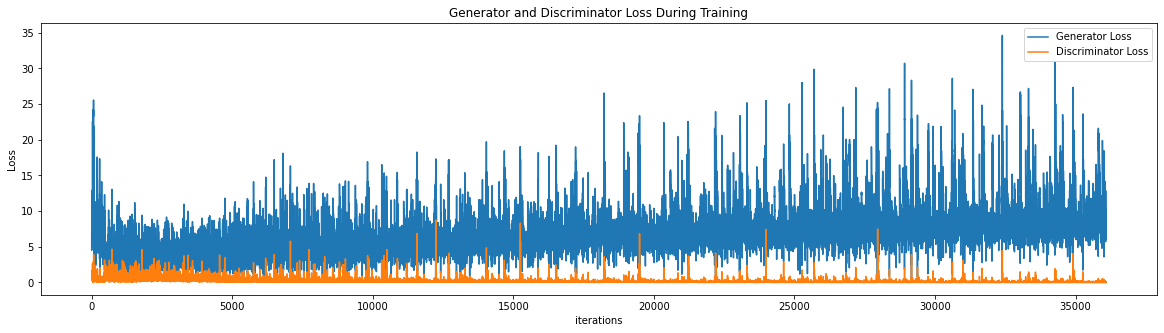

In [40]:
plt.figure(figsize=(20,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g,label="Generator Loss")
plt.plot(losses_d,label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

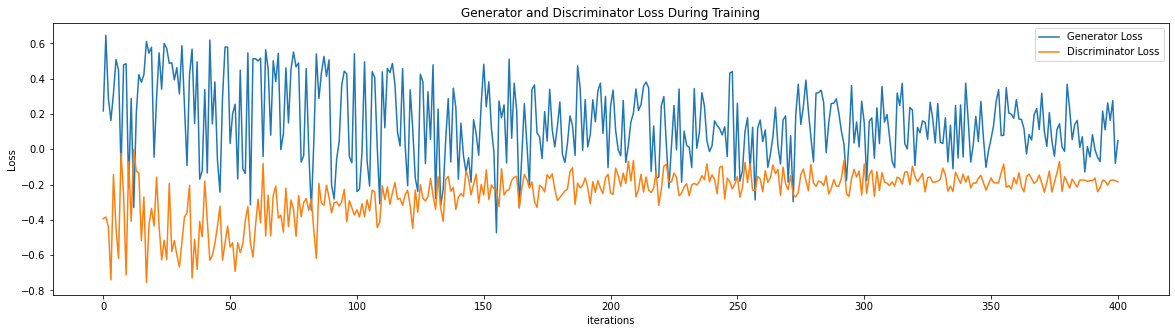

In [24]:
plt.figure(figsize=(20,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(history[0],label="Generator Loss")
plt.plot(history[1],label="Discriminator Loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [23]:
len(history)

4

In [48]:
for i in range(500):
    fixed_latent2 = torch.randn(1, nz, 1, 1, device=device)
    save_samples2(i, fixed_latent2)

Saving generates-0000.png
Saving generates-0001.png
Saving generates-0002.png
Saving generates-0003.png
Saving generates-0004.png
Saving generates-0005.png
Saving generates-0006.png
Saving generates-0007.png
Saving generates-0008.png
Saving generates-0009.png
Saving generates-0010.png
Saving generates-0011.png
Saving generates-0012.png
Saving generates-0013.png
Saving generates-0014.png
Saving generates-0015.png
Saving generates-0016.png
Saving generates-0017.png
Saving generates-0018.png
Saving generates-0019.png
Saving generates-0020.png
Saving generates-0021.png
Saving generates-0022.png
Saving generates-0023.png
Saving generates-0024.png
Saving generates-0025.png
Saving generates-0026.png
Saving generates-0027.png
Saving generates-0028.png
Saving generates-0029.png
Saving generates-0030.png
Saving generates-0031.png
Saving generates-0032.png
Saving generates-0033.png
Saving generates-0034.png
Saving generates-0035.png
Saving generates-0036.png
Saving generates-0037.png
Saving gener

Saving generates-0324.png
Saving generates-0325.png
Saving generates-0326.png
Saving generates-0327.png
Saving generates-0328.png
Saving generates-0329.png
Saving generates-0330.png
Saving generates-0331.png
Saving generates-0332.png
Saving generates-0333.png
Saving generates-0334.png
Saving generates-0335.png
Saving generates-0336.png
Saving generates-0337.png
Saving generates-0338.png
Saving generates-0339.png
Saving generates-0340.png
Saving generates-0341.png
Saving generates-0342.png
Saving generates-0343.png
Saving generates-0344.png
Saving generates-0345.png
Saving generates-0346.png
Saving generates-0347.png
Saving generates-0348.png
Saving generates-0349.png
Saving generates-0350.png
Saving generates-0351.png
Saving generates-0352.png
Saving generates-0353.png
Saving generates-0354.png
Saving generates-0355.png
Saving generates-0356.png
Saving generates-0357.png
Saving generates-0358.png
Saving generates-0359.png
Saving generates-0360.png
Saving generates-0361.png
Saving gener

In [45]:
def save_samples2(index, latent_tensors, show=True):
    fake_images = netG(latent_tensors)
    fake_fname = 'generates-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
#     if show:
#         fig, ax = plt.subplots(figsize=(8, 8))
#         ax.set_xticks([]); ax.set_yticks([])
#         ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [55]:
import numpy
from numpy import cov
from numpy import trace
from numpy import iscomplexobj
from numpy.random import random
from scipy.linalg import sqrtm
 
# calculate frechet inception distance
def calculate_fid(act1, act2):
	# calculate mean and covariance statistics
	mu1, sigma1 = act1.mean(axis=0), cov(act1, rowvar=False)
	mu2, sigma2 = act2.mean(axis=0), cov(act2, rowvar=False)
	# calculate sum squared difference between means
	ssdiff = numpy.sum((mu1 - mu2)**2.0)
	# calculate sqrt of product between cov
	covmean = sqrtm(sigma1.dot(sigma2))
	# check and correct imaginary numbers from sqrt
	if iscomplexobj(covmean):
		covmean = covmean.real
	# calculate score
	fid = ssdiff + trace(sigma1 + sigma2 - 2.0 * covmean)
	return fid
 
# define two collections of activations
act1 = random(10*2048)
act1 = act1.reshape((10,2048))
act2 = random(10*2048)
act2 = act2.reshape((10,2048))
# fid between act1 and act1
fid = calculate_fid(act1, act1)
print('FID (same): %.3f' % fid)
# fid between act1 and act2
fid = calculate_fid(act1, act2)
print('FID (different): %.3f' % fid)

ImportError: cannot import name '_pep440' from 'scipy._lib' (C:\Users\Sabby\AppData\Roaming\Python\Python38\site-packages\scipy\_lib\__init__.py)